## 4.1 Unsupervised Learning

In [5]:
import os
import sys
import re
import csv

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# For controlling cell execution
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

%matplotlib inline

In [6]:
## Toggles ##

# To disable truncation for output
np.set_printoptions(threshold=sys.maxsize)

# To disable saving segmented images
save_segmented = False # change to True to download

### Local Paths

In [21]:
## Local Path ##
path = os.path.join('.', 'QC')

## Subfolders ##
train_test_path = os.path.join(path, 'split')

mask_path = os.path.join(path, "mask")
rgb_path = os.path.join(path, "rgb")
image_files = os.listdir(rgb_path)
image_files.sort()

### Extract Train Patient Data

In [8]:
## Obtain All Train Patients ##
train_csv = os.path.join(train_test_path, 'train_subjects.csv')

# Read all patients as list
with open(train_csv, newline='') as f:
    reader = csv.reader(f)
    train_subjects = list(reader)

train_subjects = train_subjects[1:] # remove "Patient id"


## Create Train Patient List ##
train_data = []
for patient in train_subjects:
    for file in image_files:
        if re.match(patient[0], file):
            train_data.append(file)

### Define K Mean

In [9]:
def KMean(image_name, k, download):
    image = cv.cvtColor(cv.imread(os.path.join(rgb_path, image_name)), cv.COLOR_BGR2RGB)
    original_image = image.copy()

    # Convert to 2D rgb array and float type
    image = image.reshape((-1,3))
    image = np.float32(image)
    # plt.imshow(image)

    # Define criteria for termination: 100 iterations or 100 accuracy
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 1.0)

    # Perform K Means
    _, labels, centers = cv.kmeans(image, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape((original_image.shape))


    # Switch
    if download == True:
        return segmented_image
    else:
        # Plot the segmented image
        plt.imshow(segmented_image)

### Segment All Train Images
**Caution:** this block will create a new folder

In [10]:
%%skip_if save_segmented == False

# make folder for split
segmented_path = os.path.join(path, 'unsupervised_segmented_train')
os.makedirs(segmented_path, exist_ok=True)

for file in train_data:
    destination = os.path.join(segmented_path, file)
    img = KMean(file, 2, True)
    cv.imwrite(destination, img)

#### Find Optimized k Value
* k = 2
* k = 3
* k = 5
* Compute Dice coefficient

Text(0.5, 0.98, 'Tester Image Segmented with K Mean Clustering Algorithm')

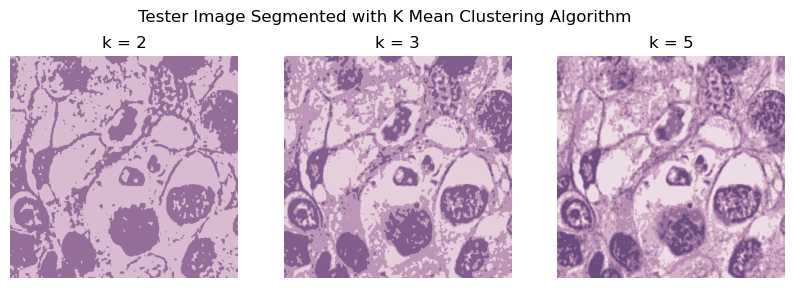

In [14]:
tester = 'TCGA-D8-A142-DX1_id-5ea4095dddda5f8398978433_left-64169_top-46171_bottom-46500_right-64506.png'

k2 = KMean(tester, 2, True)
k3 = KMean(tester, 3, True)
k5 = KMean(tester, 5, True)

plt.figure(figsize=(10, 3.25))
plt.subplot(1, 3, 1)
plt.imshow(k2)
plt.title("k = 2")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(k3)
plt.title("k = 3")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(k5)
plt.title("k = 5")
plt.axis("off")

plt.suptitle('Tester Image Segmented with K Mean Clustering Algorithm')

#### Compute Dice Coefficient

In [28]:
def dice_coefficient(img1,img2):
    intersection = np.logical_and(img1, img2)
    print(intersection)
    union = np.logical_or(img1, img2)
    dice = (2*np.sum(intersection))/(np.sum(union)+np.sum(intersection))
    return dice


# print(f'Dice similarity score is {}')